In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 複製到 Colab 工作目錄
!cp /content/drive/MyDrive/dataset_all.zip ./

# 解壓縮
!unzip -q dataset_all.zip -d ./

# 檢查解壓結果
!ls dataset_all


test  train  val


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms



# setup

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 224 * 224 * 3
num_classes = 7
batch_size = 4
num_epoch = 10

# dataset

In [5]:
class MultiLabelChiikawaDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for fname in sorted(os.listdir(label_dir)):
            if fname.endswith(".txt"):
                image_name = fname.replace(".txt", ".jpg")
                image_path = os.path.join(image_dir, image_name)
                if not os.path.exists(image_path):
                    continue

                # 產生 multi-label one-hot 向量
                label_vector = torch.zeros(num_classes)
                with open(os.path.join(label_dir, fname), "r") as f:
                    for line in f:
                        cls_id = int(line.strip().split()[0])
                        label_vector[cls_id] = 1.0

                self.image_paths.append(image_path)
                self.labels.append(label_vector)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# 資料轉換

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x)),
])

In [7]:
train_dataset = MultiLabelChiikawaDataset("dataset_all/train/images", "dataset_all/train/labels", transform)
val_dataset = MultiLabelChiikawaDataset("dataset_all/val/images", "dataset_all/val/labels", transform)
test_dataset = MultiLabelChiikawaDataset("dataset_all/test/images", "dataset_all/test/labels", transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# MLP model

In [8]:
class myMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.3),

            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),


            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.mlp(x)

# Loss

In [9]:
criterion = nn.BCEWithLogitsLoss()

# 初始化模型、loss、optimizer

In [11]:
model = myMLP(input_dim, num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-2)


# train

In [12]:
for epoch in range(num_epoch):
    model.train()
    epoch_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {epoch_loss/len(train_loader):.4f}")



Epoch 1 | Loss: 0.5365
Epoch 2 | Loss: 0.4242
Epoch 3 | Loss: 0.3929
Epoch 4 | Loss: 0.3806
Epoch 5 | Loss: 0.3731
Epoch 6 | Loss: 0.3679
Epoch 7 | Loss: 0.3659
Epoch 8 | Loss: 0.3581
Epoch 9 | Loss: 0.3531
Epoch 10 | Loss: 0.3491


In [13]:
torch.save(model.state_dict(), "chiikawa_multilabel.pt")

# evaluation

In [29]:
def evaluate_multilabel(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    per_class_threshold = [0.3, 0.32, 0.3, 0.3, 0.32, 0.24, 0.3]  # 依類別微調
    num_classes = len(per_class_threshold)
    correct_per_class = torch.zeros(num_classes)
    total_per_class = torch.zeros(num_classes)

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            outputs = model(x)

            preds = torch.sigmoid(outputs).cpu().numpy()
            labels = y.cpu().numpy()
            binary_preds = np.zeros_like(preds)

            for i in range(len(preds)):
                for j in range(len(per_class_threshold)):
                    binary_preds[i][j] = int(preds[i][j] > per_class_threshold[j])
                # 強制保留至少一個類別
                if binary_preds[i].sum() == 0:
                    binary_preds[i][np.argmax(preds[i])] = 1

            all_preds.extend(binary_preds)
            all_labels.extend(y.numpy())

            # 累加 per-class 正確率用的統計量
            preds_tensor = torch.tensor(binary_preds)
            labels_tensor = torch.tensor(labels)
            correct_per_class += ((preds_tensor == labels_tensor) * labels_tensor).sum(dim=0)
            total_per_class += labels_tensor.sum(dim=0)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    per_label_acc = (correct_per_class / (total_per_class + 1e-8)).mean().item()

    # Macro
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    # Micro
    precision_micro = precision_score(all_labels, all_preds, average='micro', zero_division=0)
    recall_micro = recall_score(all_labels, all_preds, average='micro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)

    print(f"\n=== Evaluation ===")
    # print(f"Accuracy (subset match): {acc:.4f}")
    print(f"Per-label Accuracy    : {per_label_acc:.4f}")
    print(f"Precision (macro)     : {precision_macro:.4f}")
    print(f"Recall (macro)        : {recall_macro:.4f}")
    print(f"F1 Score (macro)      : {f1_macro:.4f}")
    print(f"Precision (micro)     : {precision_micro:.4f}")
    print(f"Recall (micro)        : {recall_micro:.4f}")
    print(f"F1 Score (micro)      : {f1_micro:.4f}")

    return all_labels, all_preds

# 執行評估
evaluate_multilabel(model, test_loader)


=== Evaluation ===
Per-label Accuracy    : 0.6788
Precision (macro)     : 0.4435
Recall (macro)        : 0.6788
F1 Score (macro)      : 0.5262
Precision (micro)     : 0.4699
Recall (micro)        : 0.7267
F1 Score (micro)      : 0.5708


(array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32))

In [24]:
from sklearn.metrics import multilabel_confusion_matrix
all_labels, all_preds = evaluate_multilabel(model, test_loader)
def print_confusion_stats(y_true, y_pred, class_names):
    cm = multilabel_confusion_matrix(y_true, y_pred)
    print(f"{'Class':<12}{'TP':>6} {'FP':>6} {'FN':>6} {'TN':>6}")
    for i, name in enumerate(class_names):
        tn, fp, fn, tp = cm[i].ravel()
        print(f"{name:<12}{tp:>6} {fp:>6} {fn:>6} {tn:>6}")
print_confusion_stats(all_labels, all_preds, [
    "chiikawa", "hachiwari", "kurimanju", "momonga", "rakko", "shisa", "usagi"
])


=== Evaluation ===
Per-label Accuracy    : 0.6788
Precision (macro)     : 0.4435
Recall (macro)        : 0.6788
F1 Score (macro)      : 0.5262
Precision (micro)     : 0.4699
Recall (micro)        : 0.7267
F1 Score (micro)      : 0.5708
Class           TP     FP     FN     TN
chiikawa        69     60     12    147
hachiwari       22     22     23    221
kurimanju       23     26     18    221
momonga         28     48     12    200
rakko           27     36      7    218
shisa           10     49     10    219
usagi           71     41     12    164



=== Evaluation ===
Per-label Accuracy    : 0.6788
Precision (macro)     : 0.4435
Recall (macro)        : 0.6788
F1 Score (macro)      : 0.5262
Precision (micro)     : 0.4699
Recall (micro)        : 0.7267
F1 Score (micro)      : 0.5708
Per-class Metrics Summary:
Class        TP   FP   FN   TN Precision    Recall  F1-score   Per-Acc      Spec
----------------------------------------------------------------------------------------------------
chiikawa     69   60   12  147    0.5349    0.8519    0.6571    0.8519    0.7101
hachiwari    22   22   23  221    0.5000    0.4889    0.4944    0.4889    0.9095
kurimanju    23   26   18  221    0.4694    0.5610    0.5111    0.5610    0.8947
momonga      28   48   12  200    0.3684    0.7000    0.4828    0.7000    0.8065
rakko        27   36    7  218    0.4286    0.7941    0.5567    0.7941    0.8583
shisa        10   49   10  219    0.1695    0.5000    0.2532    0.5000    0.8172
usagi        71   41   12  164    0.6339    0.8554    0.7282    0.85

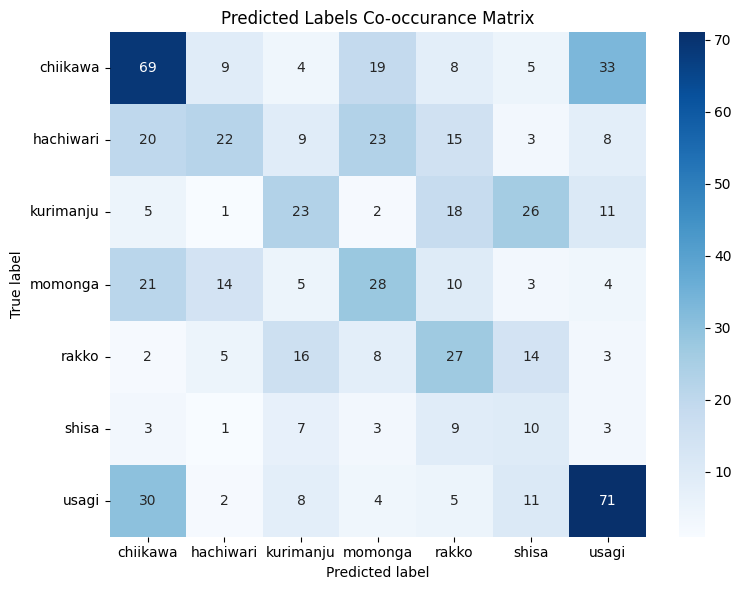

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

def plot_multilabel_summary_with_confusion_matrix(y_true, y_pred, class_names):
    num_classes = len(class_names)
    cm_list = multilabel_confusion_matrix(y_true, y_pred)

    # 計算 TP/FP/FN
    TP = cm_list[:, 1, 1]
    FP = cm_list[:, 0, 1]
    FN = cm_list[:, 1, 0]
    TN = cm_list[:, 0, 0]

    # precision / recall / f1
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

    # Per-label Accuracy = TP / (TP + FN) -> 等同於 Recall，這邊也可以另外列出
    per_label_acc = TP / (TP + FN + 1e-8)

    # Specificity = TN / (TN + FP)
    specificity = np.array([tn / (tn + fp) if (tn + fp) > 0 else 0 for tn, fp in zip(TN, FP)])

    print("Per-class Metrics Summary:")
    print(f"{'Class':<10}{'TP':>5}{'FP':>5}{'FN':>5}{'TN':>5}"
          f"{'Precision':>10}{'Recall':>10}{'F1-score':>10}{'Per-Acc':>10}{'Spec':>10}")
    print("-" * 100)
    for i in range(num_classes):
        print(f"{class_names[i]:<10}{TP[i]:>5}{FP[i]:>5}{FN[i]:>5}{TN[i]:>5}"
              f"{precision[i]:>10.4f}{recall[i]:>10.4f}{f1[i]:>10.4f}"
              f"{per_label_acc[i]:>10.4f}{specificity[i]:>10.4f}")
    # 混淆矩陣（僅視覺用）
    overall_cm = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(len(y_true)):
        true_indices = np.where(y_true[i] == 1)[0]
        pred_indices = np.where(y_pred[i] == 1)[0]
        for t in true_indices:
            for p in pred_indices:
                overall_cm[t, p] += 1

    # 📊 繪製 confusion matrix 圖片
    plt.figure(figsize=(8, 6))
    sns.heatmap(overall_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Predicted Labels Co-occurance Matrix", fontsize=12)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

class_names = ["chiikawa", "hachiwari", "kurimanju", "momonga", "rakko", "shisa", "usagi"]
all_labels, all_preds = evaluate_multilabel(model, test_loader)
plot_multilabel_summary_with_confusion_matrix(all_labels, all_preds, class_names)


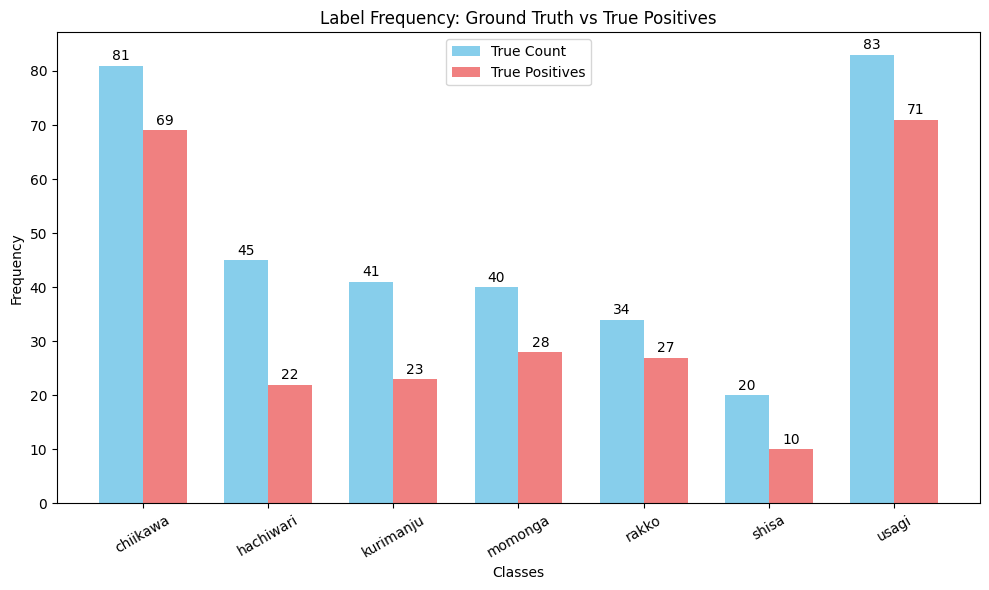

In [31]:
def plot_true_vs_tp_comparison(y_true, y_pred, class_names):
    """
    畫出每個類別的真實出現次數（True Count）與正確預測次數（True Positives，TP）
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    num_classes = len(class_names)

    # 每個類別出現幾次
    true_counts = y_true.sum(axis=0)

    # 每個類別的 TP：true 和 pred 同時為 1
    tp_counts = np.logical_and(y_true == 1, y_pred == 1).sum(axis=0)

    x = np.arange(num_classes)
    width = 0.35

    plt.figure(figsize=(10, 6))
    bars1 = plt.bar(x - width/2, true_counts, width, label='True Count', color='skyblue')
    bars2 = plt.bar(x + width/2, tp_counts, width, label='True Positives', color='lightcoral')

    # 顯示 bar 上的數字
    for i in range(num_classes):
        plt.text(x[i] - width/2, true_counts[i] + 1, f"{int(true_counts[i])}", ha='center')
        plt.text(x[i] + width/2, tp_counts[i] + 1, f"{int(tp_counts[i])}", ha='center')

    plt.xticks(x, class_names, rotation=30)
    plt.xlabel("Classes")
    plt.ylabel("Frequency")
    plt.title("Label Frequency: Ground Truth vs True Positives")
    plt.legend()
    plt.tight_layout()
    plt.show()
class_names = ["chiikawa", "hachiwari", "kurimanju", "momonga", "rakko", "shisa", "usagi"]
plot_true_vs_tp_comparison(all_labels, all_preds, class_names)

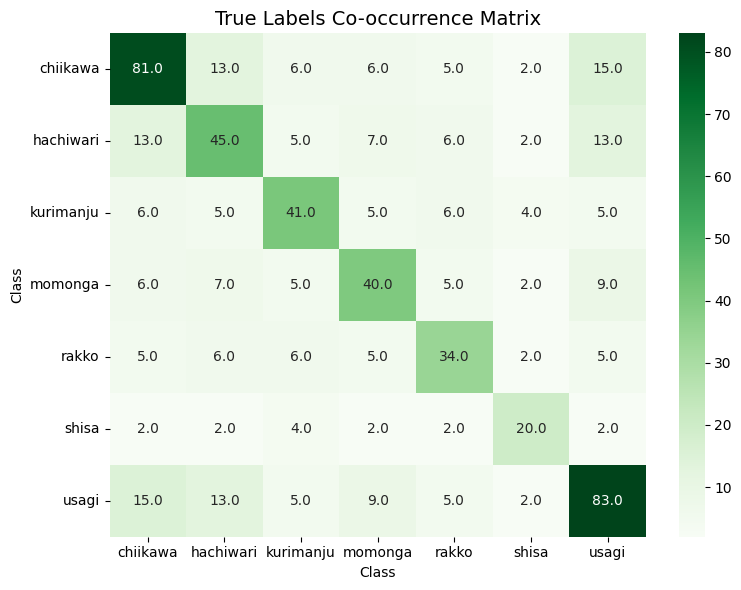

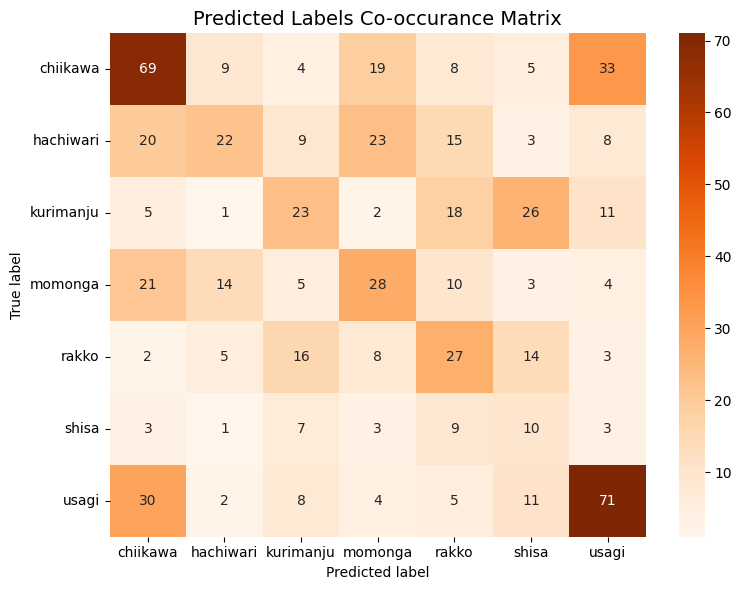

In [36]:
def plot_cooccurrence_matrix(y, class_names, title, cmap="Greens"):
    y = np.array(y)
    num_classes = len(class_names)
    co_matrix = np.zeros((num_classes, num_classes))

    for row in y:
        indices = np.where(row == 1)[0]
        for i in indices:
            for j in indices:
                co_matrix[i][j] += 1

    plt.figure(figsize=(8, 6))
    sns.heatmap(co_matrix, annot=True, fmt=".1f", cmap=cmap,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=14)
    plt.xlabel("Class")
    plt.ylabel("Class")
    plt.tight_layout()
    plt.show()

def plot_label_level_confusion_matrix(y_true, y_pred, class_names, title="Label-level Confusion Matrix"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    num_classes = len(class_names)
    confusion_matrix = np.zeros((num_classes, num_classes))

    for t_row, p_row in zip(y_true, y_pred):
        true_indices = np.where(t_row == 1)[0]
        pred_indices = np.where(p_row == 1)[0]
        for ti in true_indices:
            for pi in pred_indices:
                confusion_matrix[ti][pi] += 1

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Oranges",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=14)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

class_names = ["chiikawa", "hachiwari", "kurimanju", "momonga", "rakko", "shisa", "usagi"]

# True label 的共現情況
plot_cooccurrence_matrix(all_labels, class_names, "True Labels Co-occurrence Matrix", cmap="Greens")

# 真實 vs 預測 confusion 視覺摘要（這個才是你混淆矩陣那張圖）
plot_label_level_confusion_matrix(all_labels, all_preds, class_names, title="Predicted Labels Co-occurance Matrix")



=== Evaluation ===
Per-label Accuracy    : 0.6788
Precision (macro)     : 0.4435
Recall (macro)        : 0.6788
F1 Score (macro)      : 0.5262
Precision (micro)     : 0.4699
Recall (micro)        : 0.7267
F1 Score (micro)      : 0.5708


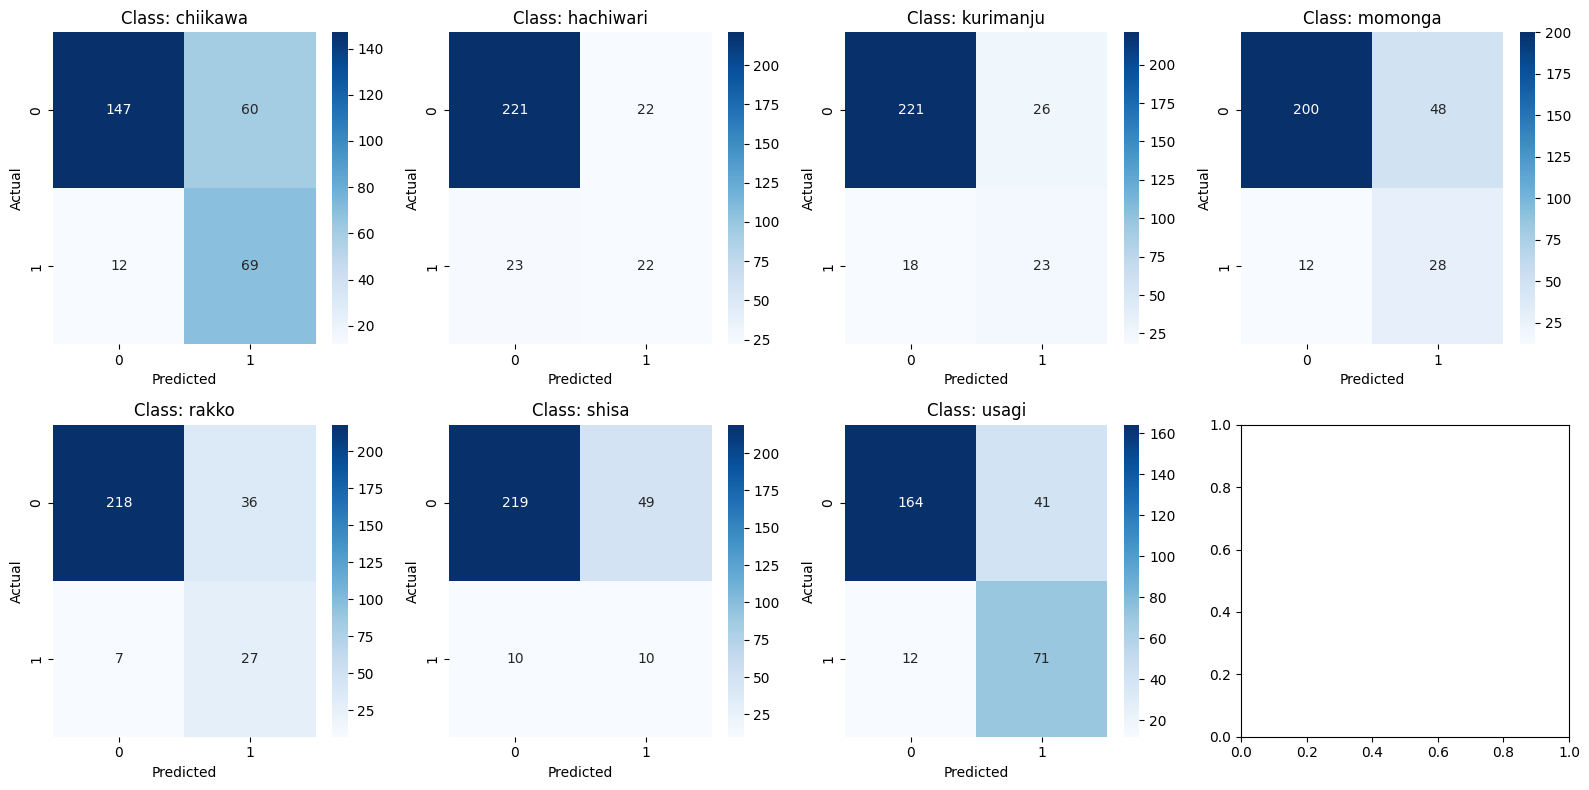

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
all_labels, all_preds = evaluate_multilabel(model, test_loader)
def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    繪製 multi-label confusion matrix（每個類別各一個）
    """
    cm = multilabel_confusion_matrix(y_true, y_pred)

    fig, axes = plt.subplots(nrows=2, ncols=(len(class_names) + 1) // 2, figsize=(16, 8))
    axes = axes.flatten()

    for i, (label, matrix) in enumerate(zip(class_names, cm)):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Class: {label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        axes[i].set_xticklabels(['0', '1'])
        axes[i].set_yticklabels(['0', '1'])

    plt.tight_layout()
    plt.show()

plot_multilabel_confusion_matrix(all_labels, all_preds, [
    "chiikawa", "hachiwari", "kurimanju", "momonga", "rakko", "shisa", "usagi"
])
